# Legit or Misinformative?

This is a WIP Notebook.  The work on building a classifier for "legit" versus "misinformative" text begins at [Classifier Training](#classifier-training).  Everything prior to that is in preparation for the assertion parsing work that I'll undertake after getting the classifier built.

The fundamental goal is to build the capability to classify new text articles as Legit or Misinformative.  The classifier is a big first step, using training sets from large research projects posted on Kaggle.

The Results Summary is in [README.md](./README.md)



## Data Source Research Notes

### Kaggle
https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection
https://www.kaggle.com/datasets/nitishjolly/news-detection-fake-or-real-dataset

### Wikipedia

### Google Fact Check
https://toolbox.google.com/factcheck/apis

### FEVER
https://fever.ai/dataset/averitec.html
has training and test datasets

#### Averitech challenge
https://fever.ai/task.html

Github query: https://github.com/search?q=Fact+Extraction+and+VERification+%28FEVER%29&type=repositories&s=updated&o=desc

Hugging Face repo: https://huggingface.co/chenxwh/AVeriTeC

### Search for NLP veracity checking
https://github.com/kianfattahy/Text-Veracity-Classification

https://www.mdpi.com/2411-9660/5/3/42

opinion phrases: https://vladsandulescu.com/opinion-phrases/?utm_content=buffer56740&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer

### spaCy

https://spacy.io/

## Semantic analysis to extract facts from test article(s)

### Using spaCy

In [2]:


import spacy
nlp = spacy.load("en_core_web_md")


In [3]:
text = "The Eiffel Tower is located in Paris. It was constructed in 1889."
doc = nlp(text)
doc


The Eiffel Tower is located in Paris. It was constructed in 1889.

In [4]:
# extract named entities
for ent in doc.ents:
    print(ent.text, '\t| ', ent.label_, '\t| ', spacy.explain(ent.label_))


The Eiffel Tower 	|  FAC 	|  Buildings, airports, highways, bridges, etc.
Paris 	|  GPE 	|  Countries, cities, states
1889 	|  DATE 	|  Absolute or relative dates or periods


In [5]:
# parse dependencies
for token in doc:
    print(token.text)
    if token.dep_ in ['nsubj', 'attr', 'acomp'] and token.head.pos_ in ['VERB', 'AUX']:
        print(token.text, token.head.text, [child for child in token.children])


The
Eiffel
Tower
is
located
in
Paris
.
It
was
constructed
in
1889
.


In [6]:
from spacy.matcher import Matcher

# Load spaCy and create a Matcher instance
nlp = spacy.load('en_core_web_md')
matcher = Matcher(nlp.vocab)

# Define a comprehensive list of patterns
patterns = [
    # Simple Subject-Verb-Object (SVO)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'dobj'}],
    # Subject-Verb-Adjective (SVA)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'acomp'}],
    # Subject-Verb-Prepositional Phrase (SVPP)
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'POS': 'ADP', 'OP': '?'}, {'DEP': 'pobj'}],
    # Passive Voice (Agent-Verb-Subject)
    [{'DEP': 'agent'}, {'POS': 'VERB'}, {'DEP': 'nsubjpass'}],
    # Adjectives or attributes linked to subjects
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'DEP': 'attr'}],
    # Handling conjunctions in factual statements
    [{'DEP': 'nsubj'}, {'POS': 'VERB'}, {'POS': 'CCONJ', 'OP': '?'}, {'DEP': 'conj'}],
    # Extended phrases involving adverbs or auxiliary verbs
    [{'DEP': 'nsubj'}, {'POS': 'AUX', 'OP': '?'}, {'POS': 'ADV', 'OP': '?'}, {'POS': 'VERB'}, {'DEP': 'dobj'}]
]

# Add patterns to the matcher
for i, pattern in enumerate(patterns):
    matcher.add(f"FACT_ASSERTION_{i}", [pattern])




In [7]:
texts = [
    "The Eiffel Tower was constructed by Gustave Eiffel.",
    "Quantum mechanics is a branch of physics.",
    "Albert Einstein developed the theory of relativity in the early 20th century.",
    "The heart pumps blood through the body.",
    "Paris, the capital of France, is known for its culture.",
    "Coffee is grown extensively in Brazil."
]

for text in texts:
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        print(f"Factual assertion found: {span.text}")


Factual assertion found: heart pumps blood
Factual assertion found: heart pumps blood


In [8]:
from spacy import displacy

text = "Quantum mechanics is a branch of physics."
doc = nlp(text)
displacy.serve(doc, style='dep',auto_select_port=True)  # This will open a web server to visually inspect the sentence


/opt/anaconda3/lib/python3.11/site-packages/spacy/util.py:1835: UserWarning: [W124] 0.0.0.0:5000 is already in use, using the nearest available port 5001 as an alternative.
  warnings.warn(Warnings.W124.format(host=host, port=start, serve_port=port))
/opt/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


# Moving on
This seems like a rabbit hole!  I'll assume that further work could get the assertion finder working.  I'm switching to building the classifier, and will use the averitech dataset to do that.

# Building a classifier

I'll follow the form of the Averitech task.  

### Datasets
https://fever.ai/dataset/averitec.html
has training and test datasets


In [4]:
## Load in the Datasets
import pandas as pd

# Load the dataset
df_dev = pd.read_json('data/data_dev.json')
df_train = pd.read_json('data/data_train.json')
df_test = pd.read_json('data/data_test.json')

# Display the first few rows of the dataset
df_dev.head()



,claim,required_reannotation,label,justification,claim_date,speaker,original_claim_url,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies,questions,cached_original_claim_url
0,"In a letter to Steve Jobs, Sean Connery refuse...",False,Refuted,The answer and sources show that the claim was...,31-10-2020,None,None,https://web.archive.org/web/20201130144023/htt...,Facebook,None,[Event/Property Claim],[Written Evidence],[{'question': 'Where was the claim first publi...,None
1,Trump Administration claimed songwriter Billie...,False,Refuted,Seems that the Wzshington post accused the sin...,31-10-2020,None,None,https://web.archive.org/web/20201103001419/htt...,Instagram,US,"[Position Statement, Event/Property Claim]",[Written Evidence],[{'question': 'Has the Trump administration vo...,None
2,Due to Imran Khan's criticism of Macron's comm...,False,Refuted,The tweet was not the official government page...,31-10-2020,Consulate General Of Pakistan France,https://web.archive.org/web/20201113115127/htt...,https://web.archive.org/web/20210629013122/htt...,Twitter,FR,"[Causal Claim, Event/Property Claim]",[Written Evidence],[{'question': 'How did Macron criticise Islam?...,https://web.archive.org/web/20201113115127/htt...
3,UNESCO declared Nadar community as the most an...,False,Refuted,This claim is refuted. According to the QA pai...,31-10-2020,Kumar Shankar,None,https://web.archive.org/web/20210225110220/htt...,Facebook,IN,[Event/Property Claim],[Written Evidence],"[{'question': 'What is Nadar?', 'answers': [{'...",None
4,Republican Matt Gaetz was part of a company th...,True,Refuted,The company was sold in 2004 and the law suit ...,31-10-2020,,None,https://web.archive.org/web/20210713185816/htt...,Facebook,US,"[Numerical Claim, Event/Property Claim]","[Written Evidence, Numerical Comparison]",[{'question': 'Did Matt Gaetz work for Chemed ...,None


In [5]:
df_train.head()

,claim,required_reannotation,label,justification,claim_date,speaker,original_claim_url,fact_checking_article,reporting_source,location_ISO_code,claim_types,fact_checking_strategies,questions,cached_original_claim_url
0,Hunter Biden had no experience in Ukraine or i...,False,Supported,No former experience stated.,25-8-2020,Pam Bondi,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Position Statement],[Written Evidence],[{'question': 'Did Hunter Biden have any exper...,None
1,Donald Trump delivered the largest tax cuts in...,False,Refuted,Three tax bills have been larger than that of ...,25-8-2020,Eric Trump,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Numerical Claim],"[Written Evidence, Numerical Comparison]",[{'question': 'Did the 2017 tax bill deliver t...,None
2,"In Nigeria … in terms of revenue share, 20% go...",False,Supported,The answer and source shows that the claim is ...,25-8-2020,Raila Odinga,https://www.youtube.com/watch?v=w5x3rmkrDOE,https://web.archive.org/web/20210307003741/htt...,YouTube,KE,[Numerical Claim],[Fact-checker Reference],[{'question': 'Kenya’s ex-prime minister Oding...,https://web.archive.org/web/20230420095918/htt...
3,Biden has pledged to stop border wall construc...,False,Supported,This claim should have been split into two par...,25-8-2020,Eric Trump,None,https://web.archive.org/web/20210111003633/htt...,Speech at The Republican National Convention,US,[Position Statement],[Written Evidence],[{'question': 'When Joe Biden participated in ...,None
4,"After the police shooting of Jacob Blake, Gov....",False,Refuted,Governor Evers did call for peace in a video s...,25-8-2020,Senator Howard Marklein,https://www.facebook.com/SenMarklein/posts/166...,https://web.archive.org/web/20210428162642/htt...,Facebook,US,[Event/Property Claim],[Written Evidence],[{'question': 'Did Governor Evers not call for...,https://web.archive.org/web/20230420103547/htt...


In [6]:
# get the count of each label
df_train['label'].value_counts()

label
Refuted                               1742
Supported                              849
Not Enough Evidence                    282
Conflicting Evidence/Cherrypicking     195
Name: count, dtype: int64

## Giving up...again!

My initial idea was to categorize as legit or misinformative based on content analysis, particularly fact detection and checking.  This proves to be not really a classification,
but an NLP and database problem.  For this current assignment, I want to focus on the classification problem, so I am switching to using existing datasets which have been classified as real or fake and comparing the accuracy of these models against each other.  In the latter stages of the project, I may revisit the parsing and database portions.


# Classifier Training

## Kaggle Datasets
1. Base set: https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection <br>
2. Large set:https://www.kaggle.com/datasets/sadmansakibmahi/fake-news-detection-dataset-with-pre-trained-model

I'll do parameter grid searches for both over Logistic Regression, Decision Tree and MultinomialNB.

In addition to using 5 fold cross-validation, I'll experiment with different sample sizes.
I will also cross test - comparing Test Set Score to Cross Test Score for a sample from the other database.



In [7]:
#import the datasets
df_Base = pd.read_csv('data/fake_and_real_news.csv')
df_FakeNews = pd.read_csv('data/Training.csv')

In [8]:
# setup a dataframe to store the results of the different model searches
results_df = pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
             'best_params': ['', '', ''],
             'best_score': ['', '', ''], 
             'fit_time': ['', '', ''],
             'best_estimator': ['', '', '']}).set_index('model')

In [54]:
# import the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer, PorterStemmer
from custom_transformers import LemmatizerStemmer  # Import from the new module
from nltk.corpus import stopwords
import nltk
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Ensure nltk resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnraegrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# chose 3 Fake and 3 Real news articles to use for the application
# chose 3 articles with label==Fake from FakeNews dataset
df_Fakes = df_FakeNews[df_FakeNews['label'] == 'Fake']
df_Fakes = df_Fakes.sample(3)
print(df_Fakes)

# chose 3 articles with label==Real from FakeNews dataset
df_Reals = df_FakeNews[df_FakeNews['label'] == 'Real']
df_Reals = df_Reals.sample(3)
print(df_Reals)

# save the chosen articles to a new dataframe
df_Chosen = pd.concat([df_Fakes, df_Reals])
# save these articles to a csv file
df_Chosen.to_csv('data/Chosen.csv', index=False)


                                                    Text label
75240  Lou Dobbs goes after Fusion GPS and their conn...  Fake
24976  President-elect Donald Trump has been a sore s...  Fake
40993  Political activist and Hillary supporter Amal ...  Fake
                                                    Text label
12074  UNITED NATIONS (Reuters) - The United Nations ...  Real
8999   WASHINGTON (Reuters) - The United States will ...  Real
15415  MANILA (Reuters) - The Philippines  anti-graft...  Real


## Stemming and Lemmatizing

In [11]:
# Custom transformer for lemmatization
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.lemmatizer.lemmatize(word) for word in text.split()]) for text in X]

In [12]:
# Custom transformer for stemming
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

## Pipeline and Parameters Setup

In [20]:
# Pipeline setup
pipeline = Pipeline([
    ('preprocess', LemmatizerStemmer()), 
    ('vectorize', CountVectorizer()),  # Placeholder; will be set to CountVectorizer or TfidfVectorizer in the param grid
    ('classifier', LogisticRegression())  # Placeholder; will be set to specific classifiers in the param grid
])

# classifier parameters for each classifier
classifier_params = {
    'Logistic': {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__max_iter': [10000],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [20],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [5],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Bayes': {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__fit_prior': [False],
        'classifier__class_prior': [None]
    }
}

In [21]:

# Parameter grid for grid search
param_grid = {
    'vectorize': [TfidfVectorizer(stop_words=stopwords.words('english')), CountVectorizer(stop_words=stopwords.words('english'))],  # Switch between CountVectorizer and TfidfVectorizer
    'vectorize__max_features': [500]
}

## Dataset Switching

In [22]:
def set_dataset(df, sample, name):
    print(f'{name}: size of dataset: {len(df)}')
    sample_df = df.sample(frac=sample, random_state=42)
    print(f'{name}: size of sample dataset: {len(sample_df)}')
    
    # set the X and y
    X = sample_df['Text']
    y = sample_df['label']

    # show the value counts for the target
    print(y.value_counts())

    return X, y

## Parameter printing and parsing

In [23]:
import ast

import re

def extract_parameters(input_string):
    # Regular expression to find content within the first pair of parentheses
    match = re.search(r'\(([^()]*)\)', input_string)
    if match:
        return match.group(1)  # Returns the content inside the parentheses
    return None  # Returns None if no parentheses found

In [24]:
def print_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")
    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    # Print each parameter and its value
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            print(f"\t\t{param} = {value}")     
        else :
            print(f"\t{key}: {value}")


In [25]:
def parse_params(param_str):
    # Regular expression to match key-value pairs in the form: 'key': value
    param_pattern = re.compile(r"'([^']+)':\s*([^,]+)")

    # Find all matches for key-value pairs in the string
    matches = param_pattern.findall(param_str)

    parm_out = {}
    
    # Store each parameter and its value in the results 
    for key, value in matches:
        if '__' in key:
            key, param = key.split('__')
            parm_out[param] = value
            print(f"\t\t{param} = {value}")
        else:
            parm_out[key] = value
            print(f"\t{key}: {value}")

    return parm_out

## Grid Search

In [40]:
def run_grids(pipeline, param_grid, classifier_params, X_train, y_train):
    results_df = pd.DataFrame({'model': list(classifier_params.keys()), 
             'best_params': [''] * len(classifier_params), 
             'best_score': [''] * len(classifier_params), 
             'fit_time': [''] * len(classifier_params), 
             'best_estimator': [''] * len(classifier_params)}).set_index('model')

    # do a grid search for each model
    for model in classifier_params.keys():
        print(f'Running grid search for {model}')
        gs = GridSearchCV(pipeline, param_grid={**param_grid, **classifier_params[model]}, cv=5, verbose=3,n_jobs=-1)
        gs.fit(X_train, y_train)
        results_df.loc[model, 'best_params'] = str(gs.best_params_)
        results_df.loc[model, 'best_score'] = gs.best_score_
        results_df.loc[model, 'fit_time'] = gs.cv_results_['mean_fit_time'][gs.best_index_]
        results_df.loc[model, 'best_estimator'] = gs.best_estimator_

    return results_df



In [ ]:
# Run for the Base dataset

X, y = set_dataset(df_Base, 0.2, 'Base')

# test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultsBase_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)

# save the results to a file
resultsBase_df.to_csv(f'results/Base_{len(X)}results.csv')

Base: size of dataset: 9900
Base: size of sample dataset: 1980
label
Real    1007
Fake     973
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Running grid search for Decision Tree
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Running grid search for Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits


### Results for the Base Dataset

In [209]:
resultsBase_df

,best_params,best_score,fit_time,best_estimator
model,,,,
Logistic,{'classifier': LogisticRegression(max_iter=100...,0.995581,6.365607,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Decision Tree,{'classifier': DecisionTreeClassifier(criterio...,0.950758,3.763134,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...",0.974747,3.71464,"(LemmatizerStemmer(), CountVectorizer(max_feat..."


In [41]:
#run for the FakeNews dataset

X, y = set_dataset(df_FakeNews, 0.1, 'FakeNews')

# test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultsFakeNews_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)

# save the results to a file
resultsFakeNews_df.to_csv(f'results/FakeNews_{len(X)}results.csv')


FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 8354
label
Real    4232
Fake    4122
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 2/5] END classifier=LogisticRegression(), classifier__C=0.1, classifier__max_iter=10000, classifier__penalty=l1, classifier__solver=liblinear, vectorize=CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...]), vectorize__max_features=500;, score=0.990 total time= 1.4min
[CV 3/5] END classifier=LogisticRegression(), classifier__C=0.1, classifier__max_iter=10000, classifier__penalty=l1, classifier_

KeyboardInterrupt: 

In [31]:
### Results for the Large Dataset

In [32]:
resultsFakeNews_df

,best_params,best_score,fit_time,best_estimator
model,,,,
Logistic,"{'classifier': LogisticRegression(C=10.0, max_...",0.993413,7.935664,"(LemmatizerStemmer(), TfidfVectorizer(max_feat..."
Decision Tree,{'classifier': DecisionTreeClassifier(criterio...,0.932934,7.204106,"(LemmatizerStemmer(), CountVectorizer(max_feat..."
Bayes,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...",0.948503,7.218914,"(LemmatizerStemmer(), CountVectorizer(max_feat..."


### Best Parameters from Grid Search

In [33]:
# pretty print the results

for model in resultsFakeNews_df.index:
    print(f"Results for FakeNews {model}")
    print(f"\tBest score: {resultsFakeNews_df.loc[model, 'best_score']}")
    print(f"\tFit time: {resultsFakeNews_df.loc[model, 'fit_time']}")
    print_params(resultsFakeNews_df.loc[model, 'best_params'])
    print('\n')

for model in resultsBase_df.index:
    print(f"Results for Base {model}")
    print(f"\tBest score: {resultsBase_df.loc[model, 'best_score']}")
    print(f"\tFit time: {resultsBase_df.loc[model, 'fit_time']}")
    print_params(resultsBase_df.loc[model, 'best_params'])
    print('\n')


Results for FakeNews Logistic
	Best score: 0.9934131736526947
	Fit time: 7.935663652420044
	classifier: LogisticRegression(C=10.0
		C = 10.0
		max_iter = 10000
		penalty = 'l1'
		solver = 'liblinear'
	vectorize: TfidfVectorizer(max_features=500
		max_features = 500}


Results for FakeNews Decision Tree
	Best score: 0.932934131736527
	Fit time: 7.2041059017181395
	classifier: DecisionTreeClassifier(criterion='entropy'
		criterion = 'entropy'
		max_depth = 20
		max_features = 'sqrt'
		min_samples_leaf = 5
		min_samples_split = 10
	vectorize: CountVectorizer(max_features=500
		max_features = 500}


Results for FakeNews Bayes
	Best score: 0.948502994011976
	Fit time: 7.218913555145264
	classifier: MultinomialNB(alpha=0.1
		alpha = 0.1
		class_prior = None
		fit_prior = False
	vectorize: CountVectorizer(max_features=500
		max_features = 500}


Results for Base Logistic
	Best score: 0.997472347562193
	Fit time: 6.520870971679687
	classifier: LogisticRegression(max_iter=10000
		C = 1.0
		max_

## Confusion Matrix for best model

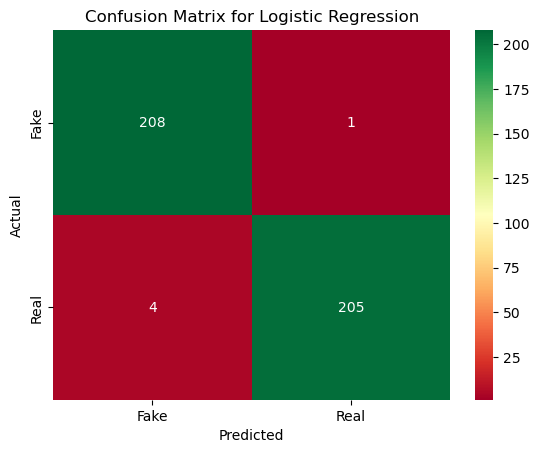

In [214]:
# give a nice plot of the confusion matrix for logistic regression
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = resultsFakeNews_df.loc['Logistic', 'best_estimator'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# use a light red to dark green color map
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn')
# replace the labels with more meaningful names
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## Comparing Results

In [14]:
# read in all of the results from the files in data/{size}results.csv
import os

uber_df = pd.DataFrame()
for file in os.listdir('results'):
    if 'results' in file:
        print(f'loading {file}')
        #parse out the size and setname from the filename which is in form {setname}_{size}results.csv
        setname = file.split('_')[0]
        size = int(file.split('_')[1].split('results')[0])

        df = pd.read_csv(f'results/{file}')
        df['size'] = size
        df['dataset'] = setname
        uber_df = pd.concat([uber_df, df])

uber_df


loading Base_4950results.csv
loading FakeNews_2088results.csv
loading Base_9900results.csv
loading Base_1980results.csv
loading FakeNews_4177results.csv
loading FakeNews_8354results.csv


,model,best_score,fit_time,best_params,best_estimator,size,dataset
0,Logistic,0.998990,10.535047,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
1,Decision Tree,0.981566,9.747898,{'classifier': DecisionTreeClassifier(max_dept...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
2,Bayes,0.975505,9.496118,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
0,Logistic,0.993413,7.935664,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
1,Decision Tree,0.932934,7.204106,{'classifier': DecisionTreeClassifier(criterio...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
2,Bayes,0.948503,7.218914,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",2088,FakeNews
0,Logistic,0.998737,20.922753,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",9900,Base
1,Decision Tree,0.976768,20.956969,{'classifier': DecisionTreeClassifier(criterio...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",9900,Base
2,Bayes,0.973737,20.876189,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",9900,Base
0,Logistic,0.997472,6.520871,{'classifier': LogisticRegression(max_iter=100...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",1980,Base


In [16]:
# sort the uber_df by model and size
uber_df.sort_values(by=['size'], inplace=True)

print_df = uber_df[['model','size', 'dataset', 'best_score', 'fit_time']]
# sort by model and size
print_df.sort_values(by=['model', 'size'], inplace=True)
#reindex by model
print_df.set_index('model', inplace=True)

print_df

/var/folders/v0/7hny_wjs4tg70rryd7blqpd00000gn/T/ipykernel_60632/773386601.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print_df.sort_values(by=['model', 'size'], inplace=True)


,size,dataset,best_score,fit_time
model,,,,
Bayes,1980,Base,0.973482,6.878384
Bayes,2088,FakeNews,0.948503,7.218914
Bayes,4177,FakeNews,0.958696,7.474342
Bayes,4950,Base,0.975505,9.496118
Bayes,8354,FakeNews,0.957055,15.505293
Bayes,9900,Base,0.973737,20.876189
Decision Tree,1980,Base,0.955189,6.539781
Decision Tree,2088,FakeNews,0.932934,7.204106
Decision Tree,4177,FakeNews,0.909918,8.145076


### Winning model of each type

In [17]:
# make best_results dataframe from the uber_df sorted by Model and RMSE
best_results = uber_df.sort_values(by=['model', 'best_score']).groupby('model').last().reset_index()

#sort the best_results by best score from highest to lowest
best_results = best_results.sort_values(by='best_score', ascending=False)

# reindex the best_results dataframe using 'Model'
best_results = best_results.set_index('model')

best_results

,best_score,fit_time,best_params,best_estimator,size,dataset
model,,,,,,
Logistic,0.998990,10.535047,"{'classifier': LogisticRegression(C=10.0, max_...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
Decision Tree,0.981566,9.747898,{'classifier': DecisionTreeClassifier(max_dept...,"Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base
Bayes,0.975505,9.496118,"{'classifier': MultinomialNB(alpha=0.1, fit_pr...","Pipeline(steps=[('preprocess', LemmatizerStemm...",4950,Base


### Show the Coefficients

In [18]:
# show the coefs for the best model
coefs = resultsBase_df.loc['Logistic', 'best_estimator'].named_steps['classifier'].coef_[0]

# get the feature names
feature_names = resultsBase_df.loc['Logistic', 'best_estimator'].named_steps['vectorize'].get_feature_names_out()

# create a dataframe of the feature names and the coefs
coefs_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})

# sort the dataframe by the absolute value of the coef
coefs_df['abs_coef'] = coefs_df['coef'].abs()
coefs_df = coefs_df.sort_values(by='abs_coef', ascending=False)


NameError: name 'resultsBase_df' is not defined

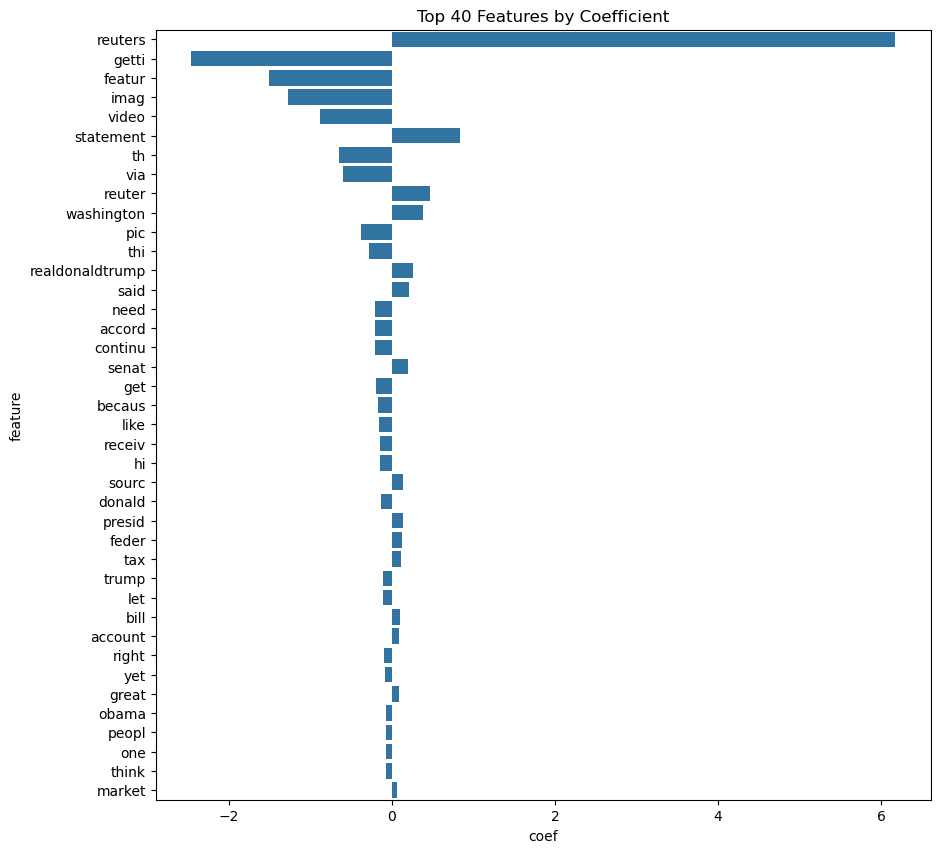

In [45]:
# plot the top 40 features by absolute value of the coef
plt.figure(figsize=(10, 10))
sns.barplot(x='coef', y='feature', data=coefs_df.iloc[:40])
plt.title('Top 40 Features by Coefficient')
plt.show()


### Plots to compare sample size on score and training time

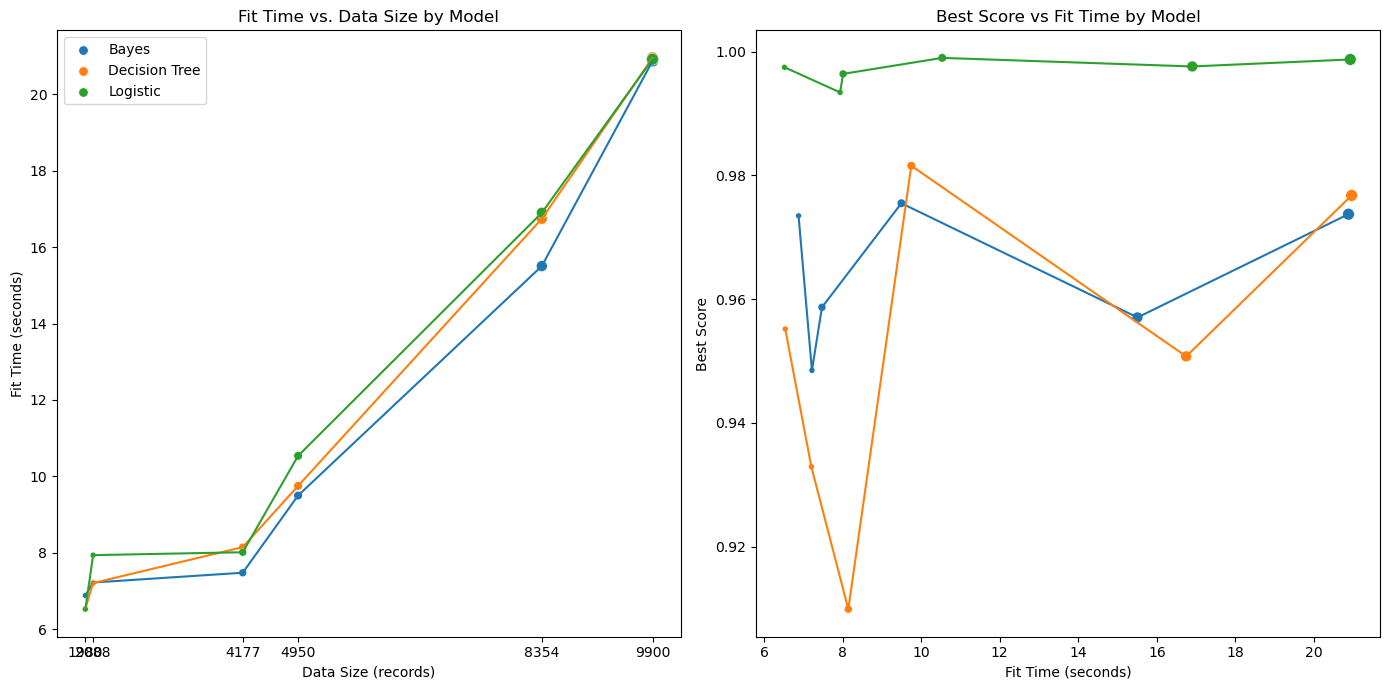

In [60]:

df = uber_df

#Normalize the size for the scatter plot
size_scale = lambda x: (x - df['size'].min()) / (df['size'].max() - df['size'].min())
df['Size'] = df['size'].map(size_scale)

# Choose a palette
pal = sns.color_palette('tab10', n_colors=df['model'].nunique())

# Creating scatter and line plots
plt.figure(figsize=(14, 7))

# Plotting Training Time vs RMSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('size')
    sns.scatterplot(data=group, x='size', y='fit_time', size='Size', color=pal[i], label=name, legend=None)
    sns.lineplot(data=group, x='size', y='fit_time', color=pal[i])

plt.title('Fit Time vs. Data Size by Model')
plt.ylabel('Fit Time (seconds)')
plt.xlabel('Data Size (records)')

#only show x ticks for the actual sizes
plt.xticks(df['size'].unique())

plt.legend()

# Plotting Training Time vs MAE
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
for i, (name, group) in enumerate(df.groupby('model')):
    group = group.sort_values('Size')
    sns.scatterplot(data=group, x='fit_time', y='best_score', size='Size', color=pal[i], label=name, legend=None)
    plt.plot(group['fit_time'], group['best_score'], color=pal[i])

plt.title('Best Score vs Fit Time by Model')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Fit Time (seconds)')
plt.ylabel('Best Score')

plt.tight_layout()
plt.show()

### Decision Tree Visualization

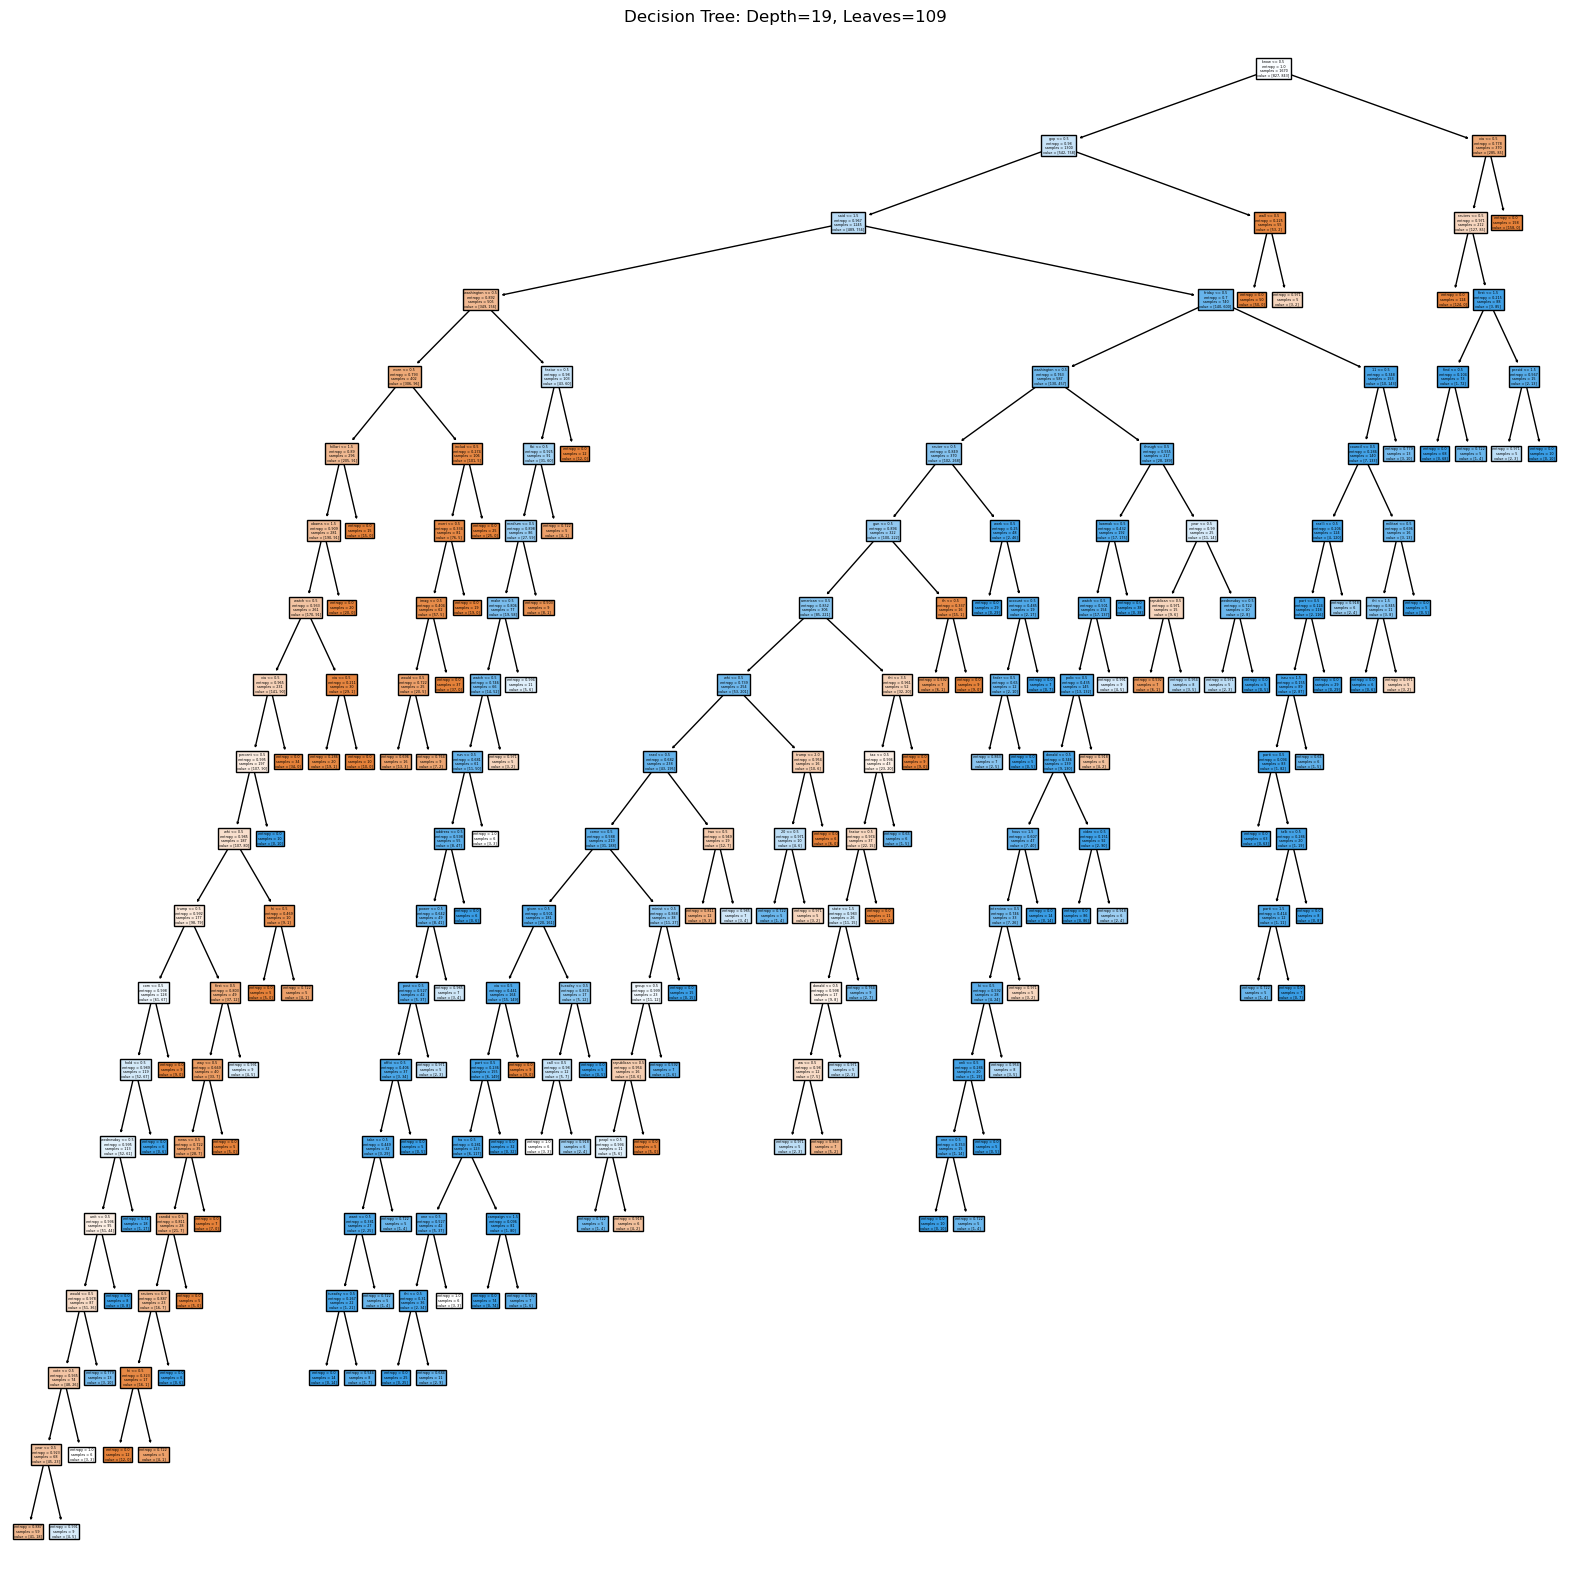

In [47]:
# show the decision tree
from sklearn.tree import plot_tree

# get the best decision tree
dt = resultsFakeNews_df.loc['Decision Tree', 'best_estimator']

# plot the tree
plt.figure(figsize=(20, 20))
plot_tree(dt.named_steps['classifier'], feature_names=dt.named_steps['vectorize'].get_feature_names_out(), filled=True)
# add a title
plt.title(f'Decision Tree: Depth={dt.named_steps["classifier"].get_depth()}, Leaves={dt.named_steps["classifier"].get_n_leaves()}')
plt.show()

### Cross Test to choose the winning model
Test each model with a random sample from the other dataset.

In [228]:
# test each FakeNews model against a test sample from df_Base
sample2_df = df_Base.sample(frac=0.5)
X_test = sample2_df['Text']
y_test = sample2_df['label']

df_crosstest = pd.DataFrame(columns=['model', 'Training Score', 'Cross Test Score']).set_index('model')

# run the test
for model in resultsFakeNews_df.index:
    print(f"Testing FakeNews {model}")
    df_crosstestFake.loc[model, 'Training Score'] = results_df.loc[model, 'best_score']
    y_pred = results_df.loc[model, 'best_estimator'].predict(X_test)
    df_crosstestFake.loc[model, 'Cross Test Score'] = sum(y_pred == y_test) / len(y_test)



Testing FakeNews Logistic
Testing FakeNews Decision Tree
Testing FakeNews Bayes


In [229]:
# show the cross training results for trained with FakeNews and tested with Base
df_crosstestFake

,Training Score,Cross Test Score
model,,
Logistic,0.997606,0.997374
Decision Tree,0.950764,0.893939
Bayes,0.957055,0.98303


In [231]:
# test each Base model against a test sample from df_FakeNews
sample3_df = df_FakeNews.sample(frac=0.05)
X_test = sample3_df['Text']
y_test = sample3_df['label']

df_crosstestBase = pd.DataFrame(columns=['model', 'Training Score', 'Cross Test Score']).set_index('model')

# run the test
for model in resultsBase_df.index:
    print(f"Testing {model}")
    df_crosstestBase.loc[model, 'Training Score'] = resultsBase_df.loc[model, 'best_score']
    y_pred = resultsBase_df.loc[model, 'best_estimator'].predict(X_test)
    df_crosstestBase.loc[model, 'Cross Test Score'] = sum(y_pred == y_test) / len(y_test)

Testing Logistic
Testing Decision Tree
Testing Bayes


In [232]:
df_crosstestBase

,Training Score,Cross Test Score
model,,
Logistic,0.995581,0.948288
Decision Tree,0.950758,0.874551
Bayes,0.974747,0.923629


### Final Model Choice!

And the winner is ... the LogisticRegression model trained on the Large dataset.

Logistic Regression
Trained on Large model sample of 8354 records
Stemmed and Lemmatized (stop_words=stopwords.words('english'))
TfidfVectorizer(max_features=500)
C = 10.0
max_iter = 10000
penalty = 'l1'
solver = 'liblinear'

Training Accuracy: 99.76%
Cross Test:        99.74%

## Pickle the final model for deployment and access through the API



In [50]:
# rerun the model with the best parameters
pipeline = Pipeline([
    ('preprocess', LemmatizerStemmer()), 
    ('vectorize', TfidfVectorizer(stop_words=stopwords.words('english'), max_features=500)),  
    ('classifier', LogisticRegression())  # Placeholder; will be set to specific classifiers in the param grid
])

# classifier parameters for each classifier
classifier_params = {
    'Logistic': {
        'classifier': [LogisticRegression()],
        'classifier__C': [10.0],
        'classifier__penalty': ['l1'],
        'classifier__max_iter': [10000],
        'classifier__solver': ['liblinear']
    }
}

# Parameter grid for grid search
param_grid = {
    'vectorize': [TfidfVectorizer(stop_words=stopwords.words('english'), max_features=500)]
}



In [51]:

# run the model
X, y = set_dataset(df_FakeNews, 0.1, 'FakeNews')

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultsFakeNews_df = run_grids(pipeline, param_grid, classifier_params, X_train, y_train)


FakeNews: size of dataset: 83539
FakeNews: size of sample dataset: 8354
label
Real    4232
Fake    4122
Name: count, dtype: int64
Running grid search for Logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END classifier=LogisticRegression(), classifier__C=10.0, classifier__max_iter=10000, classifier__penalty=l1, classifier__solver=liblinear, vectorize=TfidfVectorizer(max_features=500,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...]);, score=0.996 total time=  48.3s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=10.0, classifier__max_iter=10000, classifier__penalty=l1, classif

In [52]:
# set legitimizer to the best model
legitimizer = resultsFakeNews_df.loc['Logistic', 'best_estimator']
legitimizer

Pipeline(steps=[('preprocess', LemmatizerStemmer()),
                ('vectorize',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=10000, penalty='l1',
                                    solver='liblinear'))])

In [55]:
import joblib

joblib.dump(legitimizer, "legitimizer.pkl")

['legitimizer.pkl']

In [56]:
# reload the model
legitimizer2 = joblib.load("legitimizer.pkl")